In [13]:
import pandas as pd
import numpy as np
from pandas.plotting import autocorrelation_plot
import time
import random
import functools
    
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
from prophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose

from tqdm import tqdm
from joblib import Parallel, delayed

from datetime import date
from dateutil.relativedelta import relativedelta
from datetime import datetime

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error

from scipy.stats.mstats import gmean
import statistics

In [2]:
final_dataframe = pd.read_csv('./data/sells_time_series.csv', index_col=0)
final_dataframe.index = pd.to_datetime(final_dataframe.index)

final_dataframe.columns

Index(['fontanna do basenu', 'przypinki', 'stojak na buty', 'puzzle',
       'ściana gabionowa', 'zegar ścienny', 'dozownik mydła', 'dywan',
       'pokrywa na basen', 'roleta',
       ...
       'zestaw pufów', 'zestaw ręczników', 'zestaw słupków',
       'zestaw śrubokrętów', 'zestaw stół', 'zestaw stołków',
       'zestaw stolików', 'zestaw stołowy', 'bombka z', 'żółto łańcuch'],
      dtype='object', length=5569)

In [3]:
def return_series(df, name, key_words = None):
    """ 
    :param df: final_dataframe.
    :param name: nazwa wybrenej grupy (klastra) produktów
    :param key_words: key_words to lista słów dla których ma być wyszukany trend. Jeśli nie podacie nic, to domyślnie 
                      do key_words trafi nazwa produktów name
    """
    
    if key_words is None:
        key_words = [name]
    
    ans = False
    while ans == False:
        try:
            pytrends = TrendReq()
            pytrends.build_payload(kw_list = key_words, timeframe='2018-02-01 2021-05-01', geo='PL')
            if len(pytrends.interest_over_time()) == 0:
                raise ValueError
            ans = True
        except ValueError:
            raise
        except:
            print ("Request: ", name, "- status fail: Google 429")
            time.sleep(random.randint(15, 25))
            pass
    trends = pytrends.interest_over_time().resample('MS').sum().drop('isPartial', axis = 1)
    sells = df[name]
    return sells, trends
    

In [4]:
def get_temperature():
    temperatureDF = pd.read_csv('./data/temperature.csv')
    temperatureDF['Średnia miesięczna temperatura [°C]'] = temperatureDF['Średnia miesięczna temperatura [°C]'].astype('int64')
    temperatureDF['Data'] = temperatureDF['Data'].apply(lambda x: date(*list(map(int, x.split('-')))))
    return temperatureDF.set_index('Data').to_dict()['Średnia miesięczna temperatura [°C]']
    
def get_covid_cases():
    covidDF = pd.read_csv('./data/covid.csv')
    covidDF['Data'] = covidDF['Data'].apply(lambda x: date(*list(map(int, x.split('-'))))).apply(lambda x: x.replace(day=1))
    covidDict = covidDF.groupby('Data').sum().to_dict()['Nowe przypadki']
    covidCases = {}
    begin = date(2018, 2, 1)
    end = date(2021, 3, 1)
    while (begin < end):
        if begin in covidDict:
            covidCases[begin] = covidDict[begin]
        else:
            covidCases[begin]=0
        begin += relativedelta(months=+1)
    return covidCases

def prepareDF(name, temp, covidCases):
    future_periods = 2
    sells, trends = return_series(df = final_dataframe, name = name)
    whole_sells = final_dataframe.apply(lambda row: sum(row), axis=1)
    normalized_sells = sells.values / whole_sells
    sellsPrd = pd.DataFrame({'ds': list(sells.index), 'y': (normalized_sells / max(normalized_sells) * 100), 'trends':trends.values.squeeze()[:-future_periods], 'whole_sells':whole_sells})
    sellsPrd['cap'] = 100
    sellsPrd['floor'] = 0
    sellsPrd['ds'] = sellsPrd['ds'].dt.date
    sellsPrd['temp'] = sellsPrd['ds'].apply(lambda x: temp[x])
    sellsPrd['covid'] = sellsPrd['ds'].apply(lambda x: covidCases[x])
    return sellsPrd

temp = get_temperature()
covid = get_covid_cases()

# sells = prepareDF('zegar ścienny', temp, covid)
# sells

MODELS to globalny słownik, do którego zapisuje modele

In [5]:
MODELS = {}

In [6]:
def normalize(fi):
    acc = 0
    sv = abs([acc := acc + abs(x[0]) for x in fi][-1])
    return list(map(lambda x: (x[0]/sv, x[1]), fi))

def remove_empty_lists(lst):
    return list(filter(None, lst))

def percent_error_FB_Prophet (train_DF, test_DF, name, columns, **params):
    global MODELS
    m = Prophet(**params)
    for reg in columns:
        m.add_regressor(reg)
    m.fit(train_DF)
    forecast = m.predict(test_DF)
    y_pred = list(forecast['yhat'])
    y_true = list(test_DF['y'])
    
    MODELS[f"{name}_"+"_".join(columns)] = [m, train_DF, test_DF, forecast]
    
    return mean_squared_error(y_true, y_pred)
    

def feature_importance (train_DF, test_DF, name, columns=None, **params):
    if columns == None:
        columns = [item for item in list(train_DF.columns) if item not in ['ds', 'y', 'cap', 'floor']]
    
    error_whole_model = percent_error_FB_Prophet(train_DF, test_DF, name=name, columns=columns, **params)
    importance = []
    
    for toDrop in columns:
        columnsStay = [item for item in columns if item not in [toDrop]]
        error = percent_error_FB_Prophet(train_DF, test_DF, name=name, columns=columnsStay, **params)
        importance.append((error/error_whole_model, toDrop))
    importance.sort(reverse=True)
    return importance

def merge_feature_importances(FI):
    merged_feature_importance = {}
    for fi in FI:
        for w, att in fi:
            if att not in merged_feature_importance:
                merged_feature_importance[att] = []
            merged_feature_importance[att].append(w)
                
    merged_feature_importance_lst = []
    mean = gmean
#     mean = statistics.harmonic_mean
    for k in merged_feature_importance:
#         merged_feature_importance[k] /= len(FI)
        merged_feature_importance_lst.append((mean(merged_feature_importance[k]), k))
    merged_feature_importance_lst.sort(reverse=True)
    return merged_feature_importance_lst

def calculate_feature_importance_for_product(prod, temp, covid, splitDate):
    try:
        sells = prepareDF(prod, temp, covid)
        train_DF = sells.loc[(sells['ds'] < splitDate)]
        test_DF = sells.loc[(sells['ds'] >= splitDate)]
        return feature_importance(train_DF, test_DF, name=prod,
                               weekly_seasonality=False, daily_seasonality=False)
    except ValueError:
        return []

def feature_importance_merge_products(products, n_jobs=1, splitDate=None):
    """ 
    :param products: lista produktow(stringow).
    :param n_jobs: na ilu watkach ma dzialac, gdy n_jobs = 1 działa globalny dict MODELS
    :param splitDate: data podziału train i test datasetu
    """
    temp = get_temperature()
    covid = get_covid_cases()
    if splitDate == None:
        splitDate = date(2020, 12, 1)   
    FI = Parallel(n_jobs=n_jobs)(delayed(calculate_feature_importance_for_product)(prod, temp, covid, splitDate) for prod in products)
    FI = remove_empty_lists(FI)
    return len(FI), merge_feature_importances(FI)

In [11]:
def feature_importance_plot (fi):
    fi.sort()
    val, name = zip(*fi)
    y_pos = np.arange(len(name))
    plt.barh(y_pos, val)
    plt.yticks(y_pos, name)
    plt.axvline(x=1.0, linewidth=1, color='k')
    plt.show()

In [8]:
ln, fi = feature_importance_merge_products(['lampa', 'rama łóżka', 'dywan', 'markiza', 'zadaszenie do altany', 'szafka nocna', 'elastyczne pokrowce', 'nakładki na schody', 'zestaw mebli'], n_jobs=8)

In [9]:
print(ln)
fi

9


[(1.1467515355369893, 'trends'),
 (1.1208683325943245, 'temp'),
 (0.6715833168594361, 'covid'),
 (0.13397824896689148, 'whole_sells')]

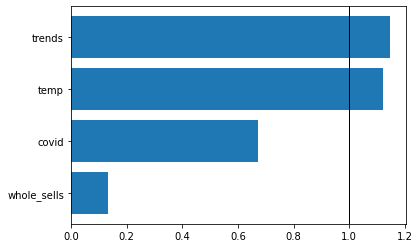

In [14]:
feature_importance_plot(fi)

# XAI dla markizy

In [15]:
prod = "markiza"

In [16]:
_, markiza = feature_importance_merge_products([prod])

In [17]:
markiza

[(4.838253818786362, 'temp'),
 (1.8576088633282368, 'trends'),
 (0.6885797442823105, 'whole_sells'),
 (0.4179556345972147, 'covid')]

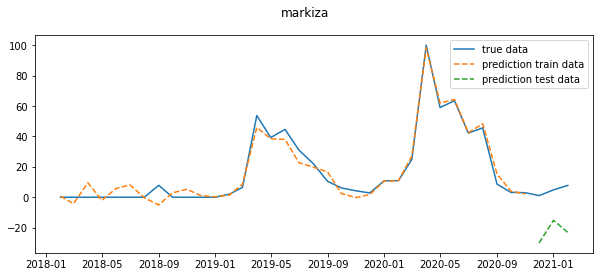

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10,4))

fig.suptitle('markiza')
cols = f"{prod}_trends_whole_sells_temp_covid"
# cols = 'trends_temp_covid'
train = MODELS[cols][1]
train_forecast = MODELS[cols][0].predict(train)
test = MODELS[cols][2]
forecast = MODELS[cols][3]

plt.plot(train["y"].append(test["y"]), label="true data")
plt.plot(train_forecast["ds"], train_forecast["yhat"], label="prediction train data", linestyle="--")
plt.plot(forecast["ds"], forecast["yhat"], label = "prediction test data", linestyle="--")
plt.legend()
plt.show()

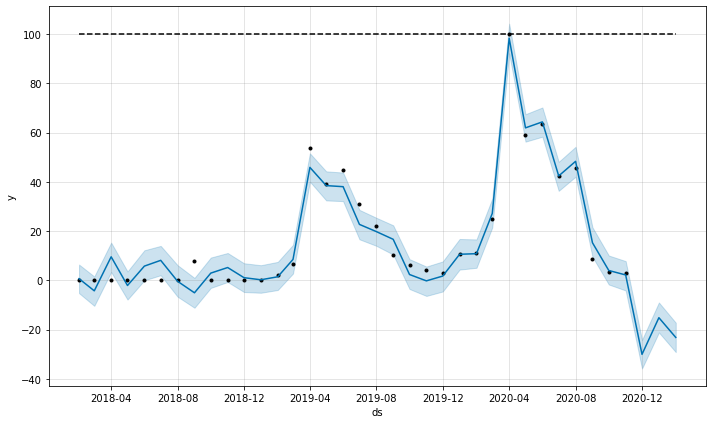

In [19]:
MODELS[cols][0].plot(train_forecast.append(forecast))
plt.show()

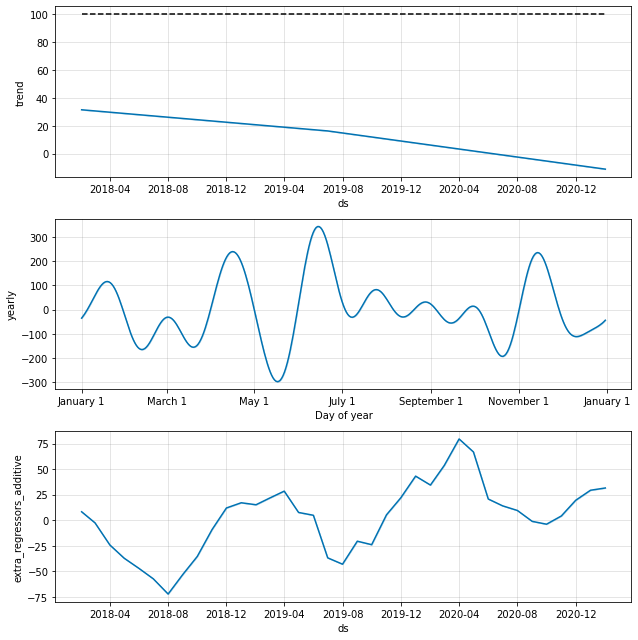

In [20]:
MODELS[cols][0].plot_components(train_forecast.append(forecast))
plt.show()

In [21]:
markiza

[(4.838253818786362, 'temp'),
 (1.8576088633282368, 'trends'),
 (0.6885797442823105, 'whole_sells'),
 (0.4179556345972147, 'covid')]

#### Koniec analizy markizy

In [ ]:
_, top10seas = feature_importance_merge_products(['siatka ogrodzeniowa', 'zestaw wypoczynkowy', 'donica gabionowa',
       'zestaw mebli', 'parasol ogrodowy', 'kosz gabionowy', 'markiza',
       'klatka dla', 'zaczepy do przyczepki', 'ławka ogrodowa'], n_jobs=8)
top10seas

In [ ]:
feature_importance_plot(top10seas)

In [ ]:
_, top10lessseas = feature_importance_merge_products(['stołki barowe', 'barierka ochronna', 'kosz na śmieci',
       'szafka łazienkowa', 'stolik barowy', 'wieszak na ubrania', 'umywalka',
       'szafka na buty', 'zestaw stolików', 'szafka nocna'], n_jobs=8)
top10lessseas

In [ ]:
feature_importance_plot(top10lessseas)

In [9]:
_, fontdobasenu = feature_importance_merge_products(['fontanna do basenu'])
fontdobasenu

['whole_sells', 'temp', 'covid']
['trends', 'temp', 'covid']
['trends', 'whole_sells', 'covid']
['trends', 'whole_sells', 'temp']


[(2680.340490264218, 'temp'),
 (1862.8103520940492, 'whole_sells'),
 (867.0256998473193, 'trends'),
 (358.52447143632986, 'covid')]

In [ ]:
_, zegarscienny = feature_importance_merge_products(['zegar ścienny'])
zegarscienny

In [ ]:
_, stojaknabuty = feature_importance_merge_products(['stojak na buty'])
stojaknabuty

In [ ]:
merge_feature_importances([fontdobasenu, zegarscienny])

In [ ]:
merge_feature_importances([fontdobasenu, zegarscienny, stojaknabuty])